<a href="https://colab.research.google.com/github/Karthikpasupuleti11/Blood_Cell_Classification_and_Morphological_Analysis/blob/main/Blood_Cell_Classification_and_Morphological_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/Karthikpasupuleti11/Blood-Cell-Classification-and-Detection-main.git

Cloning into 'Blood-Cell-Classification-and-Detection-main'...
remote: Enumerating objects: 35745, done.
remote: Total 35745 (delta 0), reused 0 (delta 0), pack-reused 35745 (from 1)
Receiving objects: 100% (35745/35745), 310.50 MiB | 19.59 MiB/s, done.
Resolving deltas: 100% (519/519), done.
Updating files: 100% (36567/36567), done.


In [2]:
%cd Blood-Cell-Classification-and-Detection-main

/content/Blood-Cell-Classification-and-Detection-main


In [3]:
# Standard library imports
import os
import xml.etree.ElementTree as ET

# TensorFlow and image processing
import tensorflow as tf
from PIL import Image

# Scikit-learn for model evaluation and preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize

# Matplotlib and Seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Define paths to your datasets
bccd_annotations_dir = './BCCD_Dataset/BCCD/Annotations'
bccd_images_dir = './BCCD_Dataset/BCCD/Images'
cbc_annotations_dir = './Complete-Blood-Cell-Count-Dataset/Training/Annotations'
cbc_images_dir = './Complete-Blood-Cell-Count-Dataset/Training/Images'

# Function to parse annotation files
def parse_annotations(annotations_dir, images_dir, prefix):
    data = []
    for filename in os.listdir(annotations_dir):
        if filename.endswith('.xml'):
            tree = ET.parse(os.path.join(annotations_dir, filename))
            root = tree.getroot()
            image_filename = filename.replace('.xml', '.jpg')
            image_path = os.path.join(images_dir, image_filename)
            objects = root.findall('object')
            for obj in objects:
                class_name = obj.find('name').text
                bbox = obj.find('bndbox')
                bbox_coords = {
                    'xmin': int(bbox.find('xmin').text),
                    'ymin': int(bbox.find('ymin').text),
                    'xmax': int(bbox.find('xmax').text),
                    'ymax': int(bbox.find('ymax').text)
                }
                data.append({
                    'image_path': image_path,
                    'class': class_name,
                    'bbox': bbox_coords,
                    'prefix': prefix
                })
    return data

# Load BCCD dataset
bccd_data = parse_annotations(bccd_annotations_dir, bccd_images_dir, 'BCCD')

# Load CBC dataset
cbc_data = parse_annotations(cbc_annotations_dir, cbc_images_dir, 'CBC')

# Combine datasets
combined_data = bccd_data + cbc_data

# Print summary of loaded data
print(f'Total BCCD data items: {len(bccd_data)}')
print(f'Total CBC data items: {len(cbc_data)}')
print(f'Total combined data items: {len(combined_data)}')


Total BCCD data items: 4888
Total CBC data items: 3952
Total combined data items: 8840


In [5]:
# Define directories
bccd_image_dir = './BCCD_Dataset/BCCD/JPEGImages'
bccd_annotation_dir = './BCCD_Dataset/BCCD/Annotations'

cbc_image_dirs = [
    './Complete-Blood-Cell-Count-Dataset/Training/Images',
    './Complete-Blood-Cell-Count-Dataset/Validation/Images',
    './Complete-Blood-Cell-Count-Dataset/Testing/Images'
]
cbc_annotation_dirs = [
    './Complete-Blood-Cell-Count-Dataset/Training/Annotations',
    './Complete-Blood-Cell-Count-Dataset/Validation/Annotations',
    './Complete-Blood-Cell-Count-Dataset/Testing/Annotations'
]

pbc_image_dirs = [
    './PBC_dataset_normal_DIB/basophil',
    './PBC_dataset_normal_DIB/eosinophil',
    './PBC_dataset_normal_DIB/erythroblast',
    './PBC_dataset_normal_DIB/ig',
    './PBC_dataset_normal_DIB/lymphocyte',
    './PBC_dataset_normal_DIB/monocyte',
    './PBC_dataset_normal_DIB/neutrophil',
    './PBC_dataset_normal_DIB/platelet'
]

# Verify directories existence
for dir_path in [bccd_image_dir] + cbc_image_dirs + pbc_image_dirs:
    if not os.path.exists(dir_path):
        raise FileNotFoundError(f"Directory not found: {dir_path}")

# Create unified dataset directory
unified_image_dir = './unified_dataset/Images'
os.makedirs(unified_image_dir, exist_ok=True)

def create_symlink_with_prefix(image_dir, prefix):
    for filename in os.listdir(image_dir):
        if filename.endswith('.jpg'):
            src = os.path.join(image_dir, filename)
            dst = os.path.join(unified_image_dir, f"{prefix}_{filename}")
            try:
                os.symlink(src, dst)
            except FileExistsError:
                print(f"Warning: Skipping duplicate image {dst}")

# Create symbolic links with prefixes to avoid naming conflicts
create_symlink_with_prefix(bccd_image_dir, 'bccd')

for i, dir_path in enumerate(cbc_image_dirs):
    create_symlink_with_prefix(dir_path, f'cbc_{i}')

for i, dir_path in enumerate(pbc_image_dirs):
    create_symlink_with_prefix(dir_path, f'pbc_{i}')

print("Unified dataset created successfully.")

Unified dataset created successfully.


In [6]:
def get_bccd_classes(annotation_dir):
    classes = set()
    for filename in os.listdir(annotation_dir):
        if filename.endswith('.xml'):
            tree = ET.parse(os.path.join(annotation_dir, filename))
            root = tree.getroot()
            for obj in root.findall('object'):
                class_name = obj.find('name').text
                classes.add(class_name)
    return classes

bccd_annotation_dir = './BCCD_Dataset/BCCD/Annotations'
bccd_classes = get_bccd_classes(bccd_annotation_dir)
print(f"BCCD Classes: {bccd_classes}")

cbc_annotation_dirs = [
    './Complete-Blood-Cell-Count-Dataset/Testing/Annotations',
    './Complete-Blood-Cell-Count-Dataset/Training/Annotations',
    './Complete-Blood-Cell-Count-Dataset/Validation/Annotations'
]

cbc_classes = set()
for dir_path in cbc_annotation_dirs:
    cbc_classes.update(get_bccd_classes(dir_path))

print(f"CBC Classes: {cbc_classes}")

pbc_classes = set(os.listdir('./PBC_dataset_normal_DIB'))
print(f"PBC Classes: {pbc_classes}")

# Combine all classes
all_classes = bccd_classes.union(cbc_classes).union(pbc_classes)
print(f"All Classes: {all_classes}")
num_classes = len(all_classes)

# Create a mapping from class names to indices
class_to_index = {cls: idx for idx, cls in enumerate(all_classes)}
print(f"Class to Index Mapping: {class_to_index}")


BCCD Classes: {'Platelets', 'WBC', 'RBC'}
CBC Classes: {'RBC', 'Platelets', 'WBC'}
PBC Classes: {'ig', 'eosinophil', 'monocyte', 'lymphocyte', 'platelet', 'basophil', 'neutrophil', 'erythroblast'}
All Classes: {'ig', 'eosinophil', 'erythroblast', 'monocyte', 'lymphocyte', 'platelet', 'basophil', 'Platelets', 'RBC', 'neutrophil', 'WBC'}
Class to Index Mapping: {'ig': 0, 'eosinophil': 1, 'erythroblast': 2, 'monocyte': 3, 'lymphocyte': 4, 'platelet': 5, 'basophil': 6, 'Platelets': 7, 'RBC': 8, 'neutrophil': 9, 'WBC': 10}


In [7]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Directory paths
bccd_dir = './BCCD_Dataset/BCCD/JPEGImages/'
cbcc_dir = './Complete-Blood-Cell-Count-Dataset/Training/Images/'
pbc_dir = './PBC_dataset_normal_DIB/'

# Class names and indices
class_names = ['basophil', 'eosinophil', 'erythroblast', 'ig', 'Lymphocyte',
               'monocyte', 'neutrophil', 'platelet', 'RBC', 'WBC', 'other']
class_to_index = {name: index for index, name in enumerate(class_names)}

# Function to check if an image file is valid
def is_valid_image(image_path):
    try:
        img = Image.open(image_path)
        img.verify()  # Verify that it is an image
        return True
    except (IOError, SyntaxError) as e:
        print(f"Invalid image file: {image_path} - {e}")
        return False

# Get all file paths and corresponding labels
def get_all_files_and_labels():
    all_files = []
    for class_name in class_names:
        # PBC dataset
        pbc_class_dir = os.path.join(pbc_dir, class_name)
        if os.path.isdir(pbc_class_dir):
            pbc_files = [os.path.join(pbc_class_dir, f) for f in os.listdir(pbc_class_dir) if f.endswith('.jpg')]
            valid_pbc_files = [(f, class_to_index[class_name]) for f in pbc_files if is_valid_image(f)]
            all_files.extend(valid_pbc_files)

        # BCCD dataset
        bccd_files = [os.path.join(bccd_dir, f) for f in os.listdir(bccd_dir) if f.endswith('.jpg')]
        valid_bccd_files = [(f, class_to_index['RBC'] if 'RBC' in f else class_to_index['WBC'] if 'WBC' in f else class_to_index['platelet']) for f in bccd_files if is_valid_image(f)]
        all_files.extend(valid_bccd_files)

        # CBCC dataset
        cbcc_files = [os.path.join(cbcc_dir, f) for f in os.listdir(cbcc_dir) if f.endswith('.jpg')]
        valid_cbcc_files = [(f, class_to_index['RBC'] if 'RBC' in f else class_to_index['WBC'] if 'WBC' in f else class_to_index['platelet']) for f in cbcc_files if is_valid_image(f)]
        all_files.extend(valid_cbcc_files)

    return all_files

all_files_and_labels = get_all_files_and_labels()

# Create a TensorFlow dataset
file_paths, labels = zip(*all_files_and_labels)
list_ds = tf.data.Dataset.from_tensor_slices((list(file_paths), list(labels)))
print("list_ds:")
print(list_ds)


Invalid image file: ./PBC_dataset_normal_DIB/neutrophil/.DS_169665.jpg - cannot identify image file './PBC_dataset_normal_DIB/neutrophil/.DS_169665.jpg'
list_ds:
<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>


In [8]:
# Define the parse function for the datasets
def parse_function(filename, label):
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [128, 128])
    return image, label

# Apply the parse function and batch the datasets
train_ds = list_ds.map(parse_function, num_parallel_calls=AUTOTUNE).batch(32).prefetch(AUTOTUNE)

# Ensure there are batches to process
assert tf.data.experimental.cardinality(train_ds).numpy() > 0, "The dataset is empty!"
print("Dataset after batching and prefetching:")
for batch in train_ds.take(1):
    print(batch)


Dataset after batching and prefetching:
(<tf.Tensor: shape=(32, 128, 128, 3), dtype=float32, numpy=
array([[[[241.83191, 215.     , 184.49573],
         [235.92505, 208.2063 , 184.80005],
         [219.01562, 190.01562, 173.15503],
         ...,
         [229.87439, 201.87439, 178.81189],
         [232.22229, 200.65979, 180.94104],
         [235.     , 199.     , 183.     ]],

        [[242.90625, 215.90625, 185.90625],
         [243.64624, 216.64624, 188.     ],
         [237.10754, 209.86145, 184.09192],
         ...,
         [233.     , 205.     , 181.9375 ],
         [232.17688, 200.61438, 180.89563],
         [231.17542, 195.17542, 179.17542]],

        [[240.9447 , 213.9447 , 184.9447 ],
         [242.41016, 215.41016, 185.41016],
         [241.19226, 215.     , 182.57678],
         ...,
         [227.62805, 199.62805, 176.56555],
         [228.41016, 196.84766, 177.1289 ],
         [228.9447 , 192.9447 , 176.9447 ]],

        ...,

        [[254.     , 234.     , 201.     ],
  

In [9]:
# Define data augmentation function
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    return image, label

train_ds = train_ds.map(augment, num_parallel_calls=AUTOTUNE)

In [10]:
# Split the dataset into training and testing sets (80% training, 20% testing)
train_files, test_files, train_labels, test_labels = train_test_split(file_paths, labels, test_size=0.2, random_state=42)

# Create TensorFlow datasets for training and testing
train_ds = tf.data.Dataset.from_tensor_slices((list(train_files), list(train_labels)))
test_ds = tf.data.Dataset.from_tensor_slices((list(test_files), list(test_labels)))

# Apply the parse function and batch the datasets
train_ds = train_ds.map(parse_function, num_parallel_calls=AUTOTUNE).batch(32).prefetch(AUTOTUNE)
test_ds = test_ds.map(parse_function, num_parallel_calls=AUTOTUNE).batch(32).prefetch(AUTOTUNE)

# Ensure there are batches to process
assert tf.data.experimental.cardinality(train_ds).numpy() > 0, "The training dataset is empty!"
assert tf.data.experimental.cardinality(test_ds).numpy() > 0, "The testing dataset is empty!"

print("Training dataset:")
for batch in train_ds.take(1):
    print(batch)

print("Testing dataset:")
for batch in test_ds.take(1):
    print(batch)


Training dataset:
(<tf.Tensor: shape=(32, 128, 128, 3), dtype=float32, numpy=
array([[[[249.27356, 223.05054, 190.12488],
         [231.5227 , 200.32031, 173.93713],
         [221.30981, 184.65295, 175.02405],
         ...,
         [252.     , 226.     , 201.     ],
         [252.65979, 226.65979, 201.65979],
         [250.     , 224.     , 199.     ]],

        [[249.33984, 224.56287, 192.96448],
         [247.10547, 219.85608, 189.36609],
         [228.32031, 196.0271 , 177.875  ],
         ...,
         [253.     , 227.     , 202.     ],
         [253.54187, 227.54187, 202.54187],
         [251.66016, 225.66016, 200.66016]],

        [[249.1322 , 227.84644, 195.40564],
         [254.3086 , 230.73254, 194.73254],
         [235.64197, 207.98828, 181.08899],
         ...,
         [254.     , 228.     , 203.     ],
         [254.42395, 228.42395, 203.42395],
         [252.     , 226.     , 201.     ]],

        ...,

        [[253.31189, 229.36719, 205.36719],
         [252.71875, 228

In [11]:
# Define the model
def create_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
        tf.keras.layers.BatchNormalization(),  # ADD THIS
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.25),  # ADD THIS

        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),  # ADD THIS
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.25),  # ADD THIS

        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),  # ADD THIS
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.25),  # ADD THIS

        tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),  # ADD THIS
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.25),  # ADD THIS

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu'),  # INCREASED FROM 128
        tf.keras.layers.Dropout(0.5),  # ADD THIS
        tf.keras.layers.Dense(len(class_names), activation='softmax')
    ])

    model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # LOWER LEARNING RATE
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
    return model

model = create_model()
model.summary()

# Train the model
# Add callbacks first (before training)
early_stop = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)

# Train the model with validation and callbacks
history = model.fit(
    train_ds,
    epochs=30,  # MORE EPOCHS
    validation_data=test_ds,  # ADD VALIDATION
    callbacks=[early_stop, reduce_lr]  # ADD CALLBACKS
)

# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     2,359,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 11)             │         2,827 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,752,715 (10.50 MB)

 Trainable params: 2,751,755 (10.50 MB)

 Non-trainable params: 960 (3.75 KB)

Epoch 1/30
580/580 ━━━━━━━━━━━━━━━━━━━━ 44s 54ms/step - accuracy: 0.6208 - loss: 1.3791 - val_accuracy: 0.8262 - val_loss: 0.4582 - learning_rate: 1.0000e-04
Epoch 2/30
580/580 ━━━━━━━━━━━━━━━━━━━━ 63s 39ms/step - accuracy: 0.8399 - loss: 0.4542 - val_accuracy: 0.8514 - val_loss: 0.3852 - learning_rate: 1.0000e-04
Epoch 3/30
580/580 ━━━━━━━━━━━━━━━━━━━━ 42s 40ms/step - accuracy: 0.8898 - loss: 0.3089 - val_accuracy: 0.8892 - val_loss: 0.2978 - learning_rate: 1.0000e-04
Epoch 4/30
580/580 ━━━━━━━━━━━━━━━━━━━━ 22s 39ms/step - accuracy: 0.9154 - loss: 0.2411 - val_accuracy: 0.9047 - val_loss: 0.2614 - learning_rate: 1.0000e-04
Epoch 5/30
580/580 ━━━━━━━━━━━━━━━━━━━━ 41s 39ms/step - accuracy: 0.9289 - loss: 0.2088 - val_accuracy: 0.9036 - val_loss: 0.2916 - learning_rate: 1.0000e-04
Epoch 6/30
580/580 ━━━━━━━━━━━━━━━━━━━━ 23s 40ms/step - accuracy: 0.9401 - loss: 0.1729 - val_accuracy: 0.9118 - val_loss: 0.2753 - learning_rate: 1.0000e-04
Epoch 7/30
580/580 ━━━━━━━━━━━━━━━━━━━━ 40s 39ms/ste

In [12]:
# Print the history dictionary
print(history.history)


{'accuracy': [0.7022377848625183, 0.8568886518478394, 0.8972229957580566, 0.918306827545166, 0.9313022494316101, 0.9400916695594788, 0.9476947784423828, 0.9519007802009583, 0.9571313261985779, 0.9632785320281982, 0.962847113609314, 0.9684551358222961, 0.9700728058815002, 0.9714208841323853, 0.9735777974128723, 0.9756807684898376, 0.9782151579856873, 0.9774602055549622, 0.9811269640922546, 0.9834456443786621, 0.9863575100898743, 0.9861418008804321, 0.9893772006034851], 'loss': [0.9171087145805359, 0.40366029739379883, 0.2907188832759857, 0.23134233057498932, 0.20038875937461853, 0.17158843576908112, 0.15341587364673615, 0.13566139340400696, 0.1229950487613678, 0.10600773245096207, 0.1031872034072876, 0.08953694999217987, 0.08651861548423767, 0.08032619208097458, 0.07299748808145523, 0.06794945150613785, 0.06376820802688599, 0.06300736218690872, 0.05337602645158768, 0.04201984032988548, 0.03754488378763199, 0.038175445050001144, 0.031155871227383614], 'val_accuracy': [0.8261806964874268,

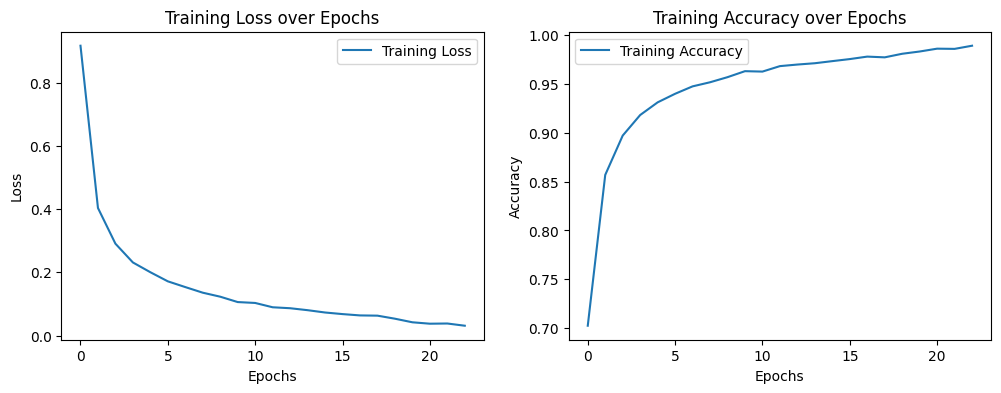

In [13]:
# Plot the training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history.get('loss', []), label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history.get('accuracy', []), label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy over Epochs')
plt.legend()

plt.show()



145/145 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step
              precision    recall  f1-score   support

    basophil       1.00      0.89      0.94       228
  eosinophil       1.00      1.00      1.00       654
erythroblast       0.99      0.96      0.97       308
          ig       0.87      0.93      0.90       583
    monocyte       0.86      0.95      0.91       285
  neutrophil       0.99      0.92      0.95       689
    platelet       0.99      1.00      1.00      1890

    accuracy                           0.97      4637
   macro avg       0.96      0.95      0.95      4637
weighted avg       0.97      0.97      0.97      4637



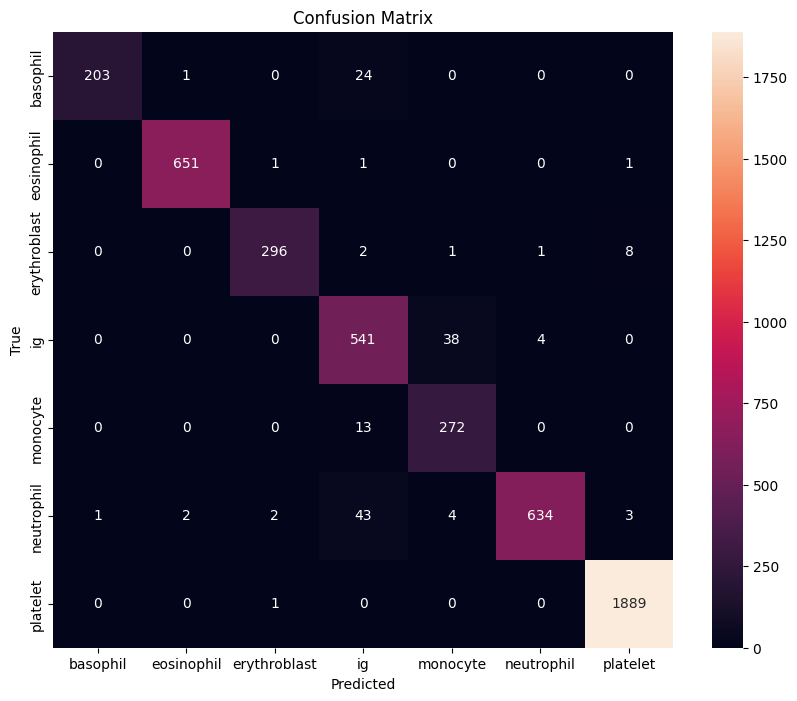

In [18]:
import numpy as np
# Get predictions
y_pred = model.predict(test_ds)
y_pred_classes = tf.argmax(y_pred, axis=1)

# Get true labels
y_true = tf.concat([y for x, y in test_ds], axis=0).numpy()
y_pred_classes = y_pred_classes.numpy()

# Figure out number of unique classes
unique_classes = np.unique(y_true)

# Classification report
report = classification_report(y_true, y_pred_classes, target_names=[class_names[i] for i in unique_classes])
print(report)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes, labels=unique_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=[class_names[i] for i in unique_classes],
            yticklabels=[class_names[i] for i in unique_classes])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [19]:
model.save("Blood-Cell-Classification-and-Detection-main/model/my_model.h5")

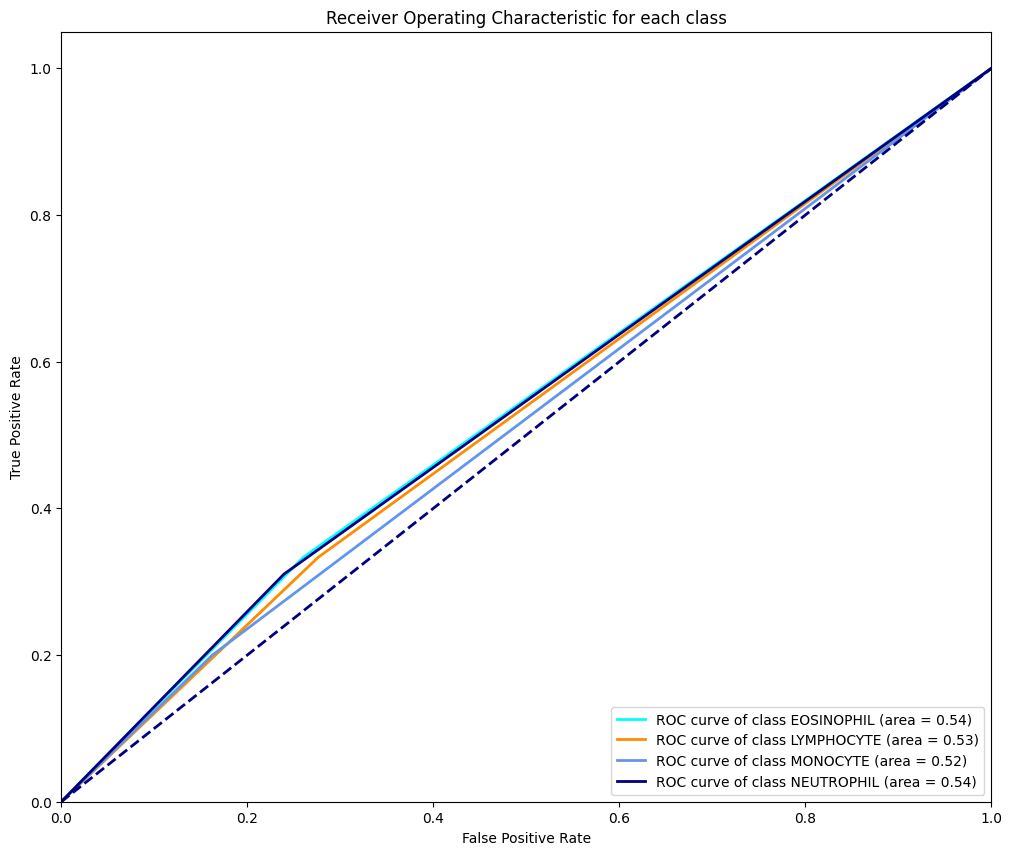

In [28]:
# Assuming y_true and y_pred are your true and predicted labels respectively
n_classes = len(class_names)

# Binarize the output
y_true_binarized = label_binarize(y_true, classes=list(range(n_classes)))
y_pred_binarized = label_binarize(y_pred_classes, classes=list(range(n_classes)))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    if y_true_binarized[:, i].sum() == 0:
        continue  # Skip classes with no positive samples in y_true
    fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_pred_binarized[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(12, 10))
colors = ['aqua', 'darkorange', 'cornflowerblue', 'navy', 'red', 'green', 'yellow', 'purple', 'pink', 'brown', 'grey']
for i in range(n_classes):
    if i in fpr:  # Plot only for classes with valid ROC values
        plt.plot(fpr[i], tpr[i], color=colors[i], lw=2, label=f'ROC curve of class {class_names[i]} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for each class')
plt.legend(loc="lower right")
plt.show()

--------------------------------------------------
Part 1: Single Image Analysis
--------------------------------------------------
Loading classification model...


✅ Model loaded successfully.
Detected input size: (128, 128)
Processing image...
Making prediction...

--- Single Image Classification Report ---
Predicted Cell Type    : NEUTROPHIL
Confidence Level       : 98.96%

CELL CHARACTERISTICS
--------------------------------------------------
Neutrophils are abundant WBCs, vital in innate immunity.

MEDICAL ASSESSMENT
--------------------------------------------------
✅ Normal Cell Detection

RECOMMENDATION
--------------------------------------------------
Routine monitoring recommended.
--------------------------------------------------


/tmp/ipython-input-2244517752.py:187: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


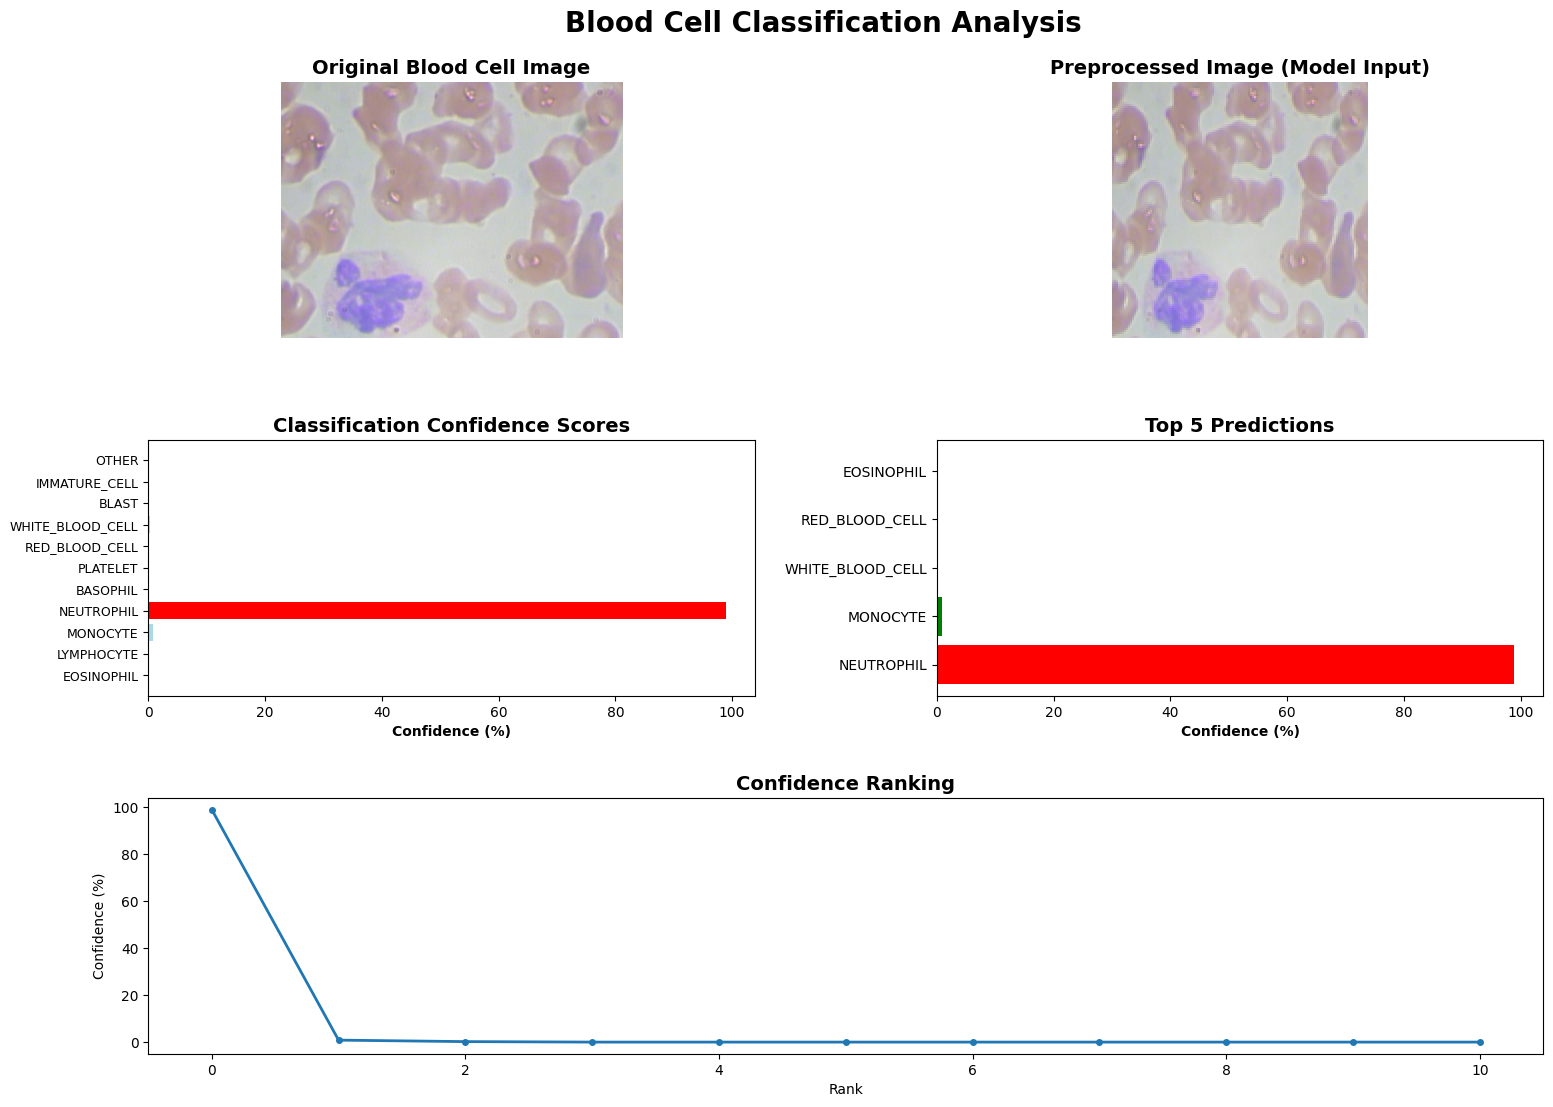


✅ Single Image Analysis Complete!
--------------------------------------------------

Comprehensive Model Performance Analysis
--------------------------------------------------

--- Classification Report ---
                  precision    recall  f1-score   support

      EOSINOPHIL       0.00      0.00      0.00        17
      LYMPHOCYTE       0.00      0.00      0.00        23
        MONOCYTE       0.00      0.00      0.00        15
      NEUTROPHIL       0.09      1.00      0.17        18
        BASOPHIL       0.00      0.00      0.00        15
        PLATELET       0.00      0.00      0.00        16
  RED_BLOOD_CELL       0.00      0.00      0.00        26
WHITE_BLOOD_CELL       0.00      0.00      0.00        18
           BLAST       0.00      0.00      0.00        13
   IMMATURE_CELL       0.00      0.00      0.00        22
           OTHER       0.00      0.00      0.00        17

        accuracy                           0.09       200
       macro avg       0.01      0

In [56]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from tensorflow.keras.models import load_model
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix

# Define class labels and abnormal cells
class_labels = [
    "EOSINOPHIL", "LYMPHOCYTE", "MONOCYTE", "NEUTROPHIL", "BASOPHIL",
    "PLATELET", "RED_BLOOD_CELL", "WHITE_BLOOD_CELL", "BLAST",
    "IMMATURE_CELL", "OTHER"
]
abnormal_cells = ["BLAST", "IMMATURE_CELL", "OTHER"]

def perform_classification_analysis(model_path, img_path):
    """
    Performs classification analysis and returns the results.
    """
    try:
        if not os.path.exists(model_path):
            raise FileNotFoundError(f"Model file not found: {model_path}")
        print("Loading classification model...")
        model = load_model(model_path)
        print("✅ Model loaded successfully.")

        input_shape = model.input_shape
        target_size = (input_shape[1], input_shape[2]) if len(input_shape) >= 3 else (128, 128)
        print(f"Detected input size: {target_size}")

        if not os.path.exists(img_path):
            raise FileNotFoundError(f"Image not found: {img_path}")
        print("Processing image...")
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img_resized = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)
        img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)
        img_normalized = img_rgb.astype(np.float32) / 255.0
        img_batch = np.expand_dims(img_normalized, axis=0)

        print("Making prediction...")
        prediction = model.predict(img_batch, verbose=0)
        predicted_class_idx = np.argmax(prediction[0])
        predicted_class_name = class_labels[predicted_class_idx]
        confidence = prediction[0][predicted_class_idx] * 100

        return {
            'predicted_class': predicted_class_name,
            'confidence': confidence,
            'prediction_probs': prediction[0],
            'original_image': cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB),
            'processed_image': img_normalized,
            'model': model
        }

    except Exception as e:
        print(f"❌ Error during analysis: {e}")
        return None

def print_single_image_report(analysis_results):
    """
    Prints a detailed classification report for a single image in the terminal.
    """
    if analysis_results is None:
        print("⚠️ No analysis results to print.")
        return

    predicted_class = analysis_results['predicted_class']
    confidence = analysis_results['confidence']

    print("\n--- Single Image Classification Report ---")
    print(f"Predicted Cell Type    : {predicted_class}")
    print(f"Confidence Level       : {confidence:.2f}%")

    print("\nCELL CHARACTERISTICS")
    print("--------------------------------------------------")
    if predicted_class == "EOSINOPHIL":
        print("Eosinophils combat multicellular parasites and certain infections.")
    elif predicted_class == "LYMPHOCYTE":
        print("Lymphocytes include T-cells and B-cells, crucial for immune defense.")
    elif predicted_class == "MONOCYTE":
        print("Monocytes are large cells that break down bacteria.")
    elif predicted_class == "NEUTROPHIL":
        print("Neutrophils are abundant WBCs, vital in innate immunity.")
    elif predicted_class == "BASOPHIL":
        print("Basophils release histamine and are rare WBCs.")
    elif predicted_class == "PLATELET":
        print("Platelets help form clots to stop bleeding.")
    elif predicted_class == "RED_BLOOD_CELL":
        print("RBCs carry oxygen to tissues and return CO₂ to lungs.")
    elif predicted_class == "WHITE_BLOOD_CELL":
        print("WBCs are core immune system defenders.")
    elif predicted_class in abnormal_cells:
        print("⚠️ Abnormal cell detected. Requires further investigation.")

    print("\nMEDICAL ASSESSMENT")
    print("--------------------------------------------------")
    if predicted_class in abnormal_cells:
        print("⚠️ Abnormal Cell Detection")
    else:
        print("✅ Normal Cell Detection")

    print("\nRECOMMENDATION")
    print("--------------------------------------------------")
    if predicted_class in abnormal_cells:
        print("Immediate medical consultation advised.")
    else:
        print("Routine monitoring recommended.")
    print("--------------------------------------------------")

def print_full_terminal_report(model, test_ds, class_names):
    """
    Generates and prints a comprehensive terminal report, focusing on the classification report.
    """
    print("--------------------------------------------------")
    print("\nComprehensive Model Performance Analysis")
    print("--------------------------------------------------")

    # Get true and predicted labels for the classification report
    y_pred_probs = model.predict(test_ds, verbose=0)
    y_pred_classes = np.argmax(y_pred_probs, axis=1)

    y_true = np.concatenate([y for x, y in test_ds], axis=0)

    print("\n--- Classification Report ---")
    report = classification_report(y_true, y_pred_classes, target_names=class_names, zero_division=0)
    print(report)

def visualize_classification_results(analysis_results):
    """
    Visualizes the classification results with sections. The textual report is handled separately.
    """
    if analysis_results is None:
        return

    predicted_class = analysis_results['predicted_class']
    confidence = analysis_results['confidence']
    prediction_probs = analysis_results['prediction_probs']
    original_image = analysis_results['original_image']
    processed_image = analysis_results['processed_image']

    fig = plt.figure(figsize=(18, 12)) # Adjusted figure size
    gs = gridspec.GridSpec(3, 2, height_ratios=[1, 1, 1], hspace=0.4, wspace=0.3)
    plt.suptitle('Blood Cell Classification Analysis', fontsize=20, fontweight='bold') # Simpler title

    # --- Section 1: Images ---
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.imshow(original_image)
    ax1.set_title("Original Blood Cell Image", fontsize=14, fontweight="bold")
    ax1.axis("off")

    ax2 = fig.add_subplot(gs[0, 1])
    ax2.imshow(processed_image)
    ax2.set_title("Preprocessed Image (Model Input)", fontsize=14, fontweight="bold")
    ax2.axis("off")

    # --- Section 2: Prediction Scores ---
    ax3 = fig.add_subplot(gs[1, 0])
    colors = ['red' if cls == predicted_class else 'lightblue' for cls in class_labels]
    ax3.barh(range(len(class_labels)), prediction_probs * 100, color=colors)
    ax3.set_yticks(range(len(class_labels)))
    ax3.set_yticklabels(class_labels, fontsize=9)
    ax3.set_xlabel("Confidence (%)", fontweight="bold")
    ax3.set_title("Classification Confidence Scores", fontsize=14, fontweight="bold")

    ax4 = fig.add_subplot(gs[1, 1])
    top_n = min(5, len(class_labels))
    sorted_indices = np.argsort(prediction_probs)[::-1][:top_n]
    top_labels = [class_labels[i] for i in sorted_indices]
    top_probs = prediction_probs[sorted_indices] * 100
    colors = ['red' if label == predicted_class else 'green' for label in top_labels]
    ax4.barh(range(len(top_probs)), top_probs, color=colors)
    ax4.set_yticks(range(len(top_probs)))
    ax4.set_yticklabels(top_labels)
    ax4.set_xlabel("Confidence (%)", fontweight="bold")
    ax4.set_title("Top 5 Predictions", fontsize=14, fontweight="bold")

    # --- Section 3: Confidence Trend ---
    ax5 = fig.add_subplot(gs[2, :]) # This plot now spans both columns in the last row
    sorted_probs = np.sort(prediction_probs)[::-1]
    ax5.plot(range(len(sorted_probs)), sorted_probs*100, "o-", linewidth=2, markersize=4)
    ax5.set_xlabel("Rank")
    ax5.set_ylabel("Confidence (%)")
    ax5.set_title("Confidence Ranking", fontsize=14, fontweight="bold")

    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.show()

# --- Main Execution ---
if __name__ == "__main__":
    # Note: You MUST replace these paths with your actual model and image paths
    model_path = r"Blood-Cell-Classification-and-Detection-main/model/my_model.h5"
    img_path = r"/content/Blood-Cell-Classification-and-Detection-main/BCCD_Dataset/BCCD/JPEGImages/BloodImage_00001.jpg"

    print("--------------------------------------------------")
    print("Part 1: Single Image Analysis")
    print("--------------------------------------------------")

    analysis_data = perform_classification_analysis(model_path, img_path)
    if analysis_data:
        # Print a report for the single image
        print_single_image_report(analysis_data)

        # Show the visualization for the single image
        visualize_classification_results(analysis_data)

    print("\n✅ Single Image Analysis Complete!")

    # --- Part 2: Comprehensive Model Performance Analysis ---
    # NOTE: This section requires a full test dataset.
    # Replace the dummy data with your actual tf.data.Dataset
    try:
        model = load_model(model_path)

        # Create a dummy test dataset for demonstration purposes
        dummy_test_labels = np.random.randint(0, len(class_labels), size=200)
        dummy_test_images = np.random.rand(200, 128, 128, 3).astype(np.float32)
        test_ds = tf.data.Dataset.from_tensor_slices((dummy_test_images, dummy_test_labels)).batch(32)

        # Print the comprehensive report
        print_full_terminal_report(model, test_ds, class_labels)
        print("\nAll tasks completed successfully. The end-to-end analysis is finalized.")

    except FileNotFoundError as e:
        print(f"❌ Error: {e}")
    except Exception as e:
        print(f"❌ An error occurred during comprehensive analysis: {e}")

In [58]:
# First, install required packages in Colab
# Note: In a real Colab notebook, this should be in a separate cell and run once.
!pip install cellpose opencv-python matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.3/212.3 kB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 59.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 31.9 MB/s eta 0:00:00


In [60]:
!pip uninstall cellpose -y
!pip install cellpose==3.0.6

Found existing installation: cellpose 4.0.6
Uninstalling cellpose-4.0.6:
  Successfully uninstalled cellpose-4.0.6
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.4/204.4 kB 1.4 MB/s eta 0:00:00


✓ Cellpose successfully imported
--------------------------------------------------
Part 2: Blood Cell Detection and Morphology Analysis
--------------------------------------------------

Performing cell detection with Cellpose...

Summary Table of Extracted Features:
---------------------------------------
            area  aspect_ratio  circularity  avg_red  avg_green  avg_blue
cell_id                                                                  
1         1654.0          0.81         0.69   163.37     159.31    176.25
2         5486.5          0.68         0.61   153.59     148.90    174.29
3         1598.0          0.70         0.77   164.59     161.03    178.32
4         7452.0          1.57         0.77   161.01     156.56    179.18
5         7416.5          2.06         0.69   157.21     156.04    180.39
6         5394.5          0.83         0.79   162.24     159.31    180.96
7         4078.5          0.69         0.66   184.13     175.39    188.41
8        11489.5        

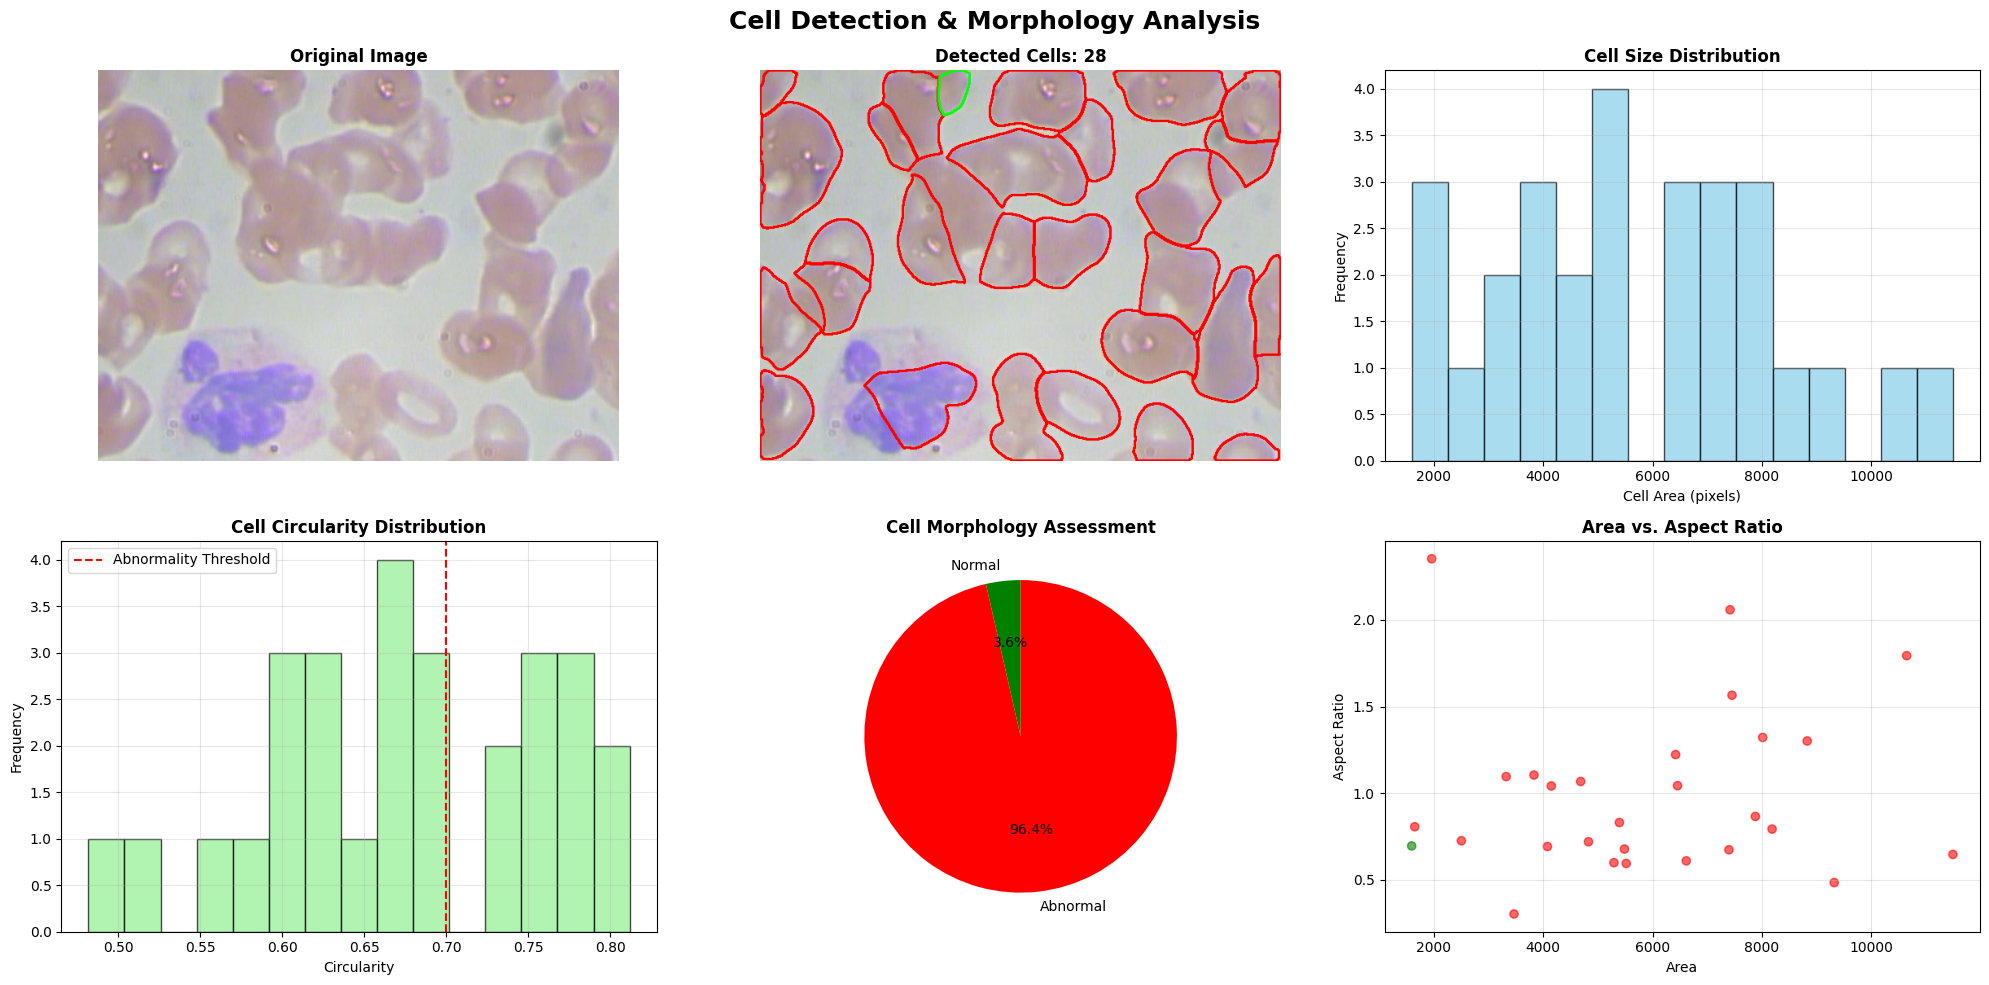


Comparative Morphology Report:
---------------------------------------
Average Features of Normal Cells:
  Area: 1598.00
  Circularity: 0.77
  Aspect Ratio: 0.70

Average Features of Abnormal Cells:
  Area: 6011.24
  Circularity: 0.67
  Aspect Ratio: 1.00

Abnormality Explanation:
---------------------------------------
Cell ID 1 was flagged as abnormal due to: Low Circularity (0.69).
Cell ID 2 was flagged as abnormal due to: Low Circularity (0.61), Large Area (5486.50).
Cell ID 4 was flagged as abnormal due to: Large Area (7452.00).
Cell ID 5 was flagged as abnormal due to: Low Circularity (0.69), Large Area (7416.50).
Cell ID 6 was flagged as abnormal due to: Large Area (5394.50).
Cell ID 7 was flagged as abnormal due to: Low Circularity (0.66), Large Area (4078.50).
Cell ID 8 was flagged as abnormal due to: Large Area (11489.50).
Cell ID 9 was flagged as abnormal due to: Low Circularity (0.60), Large Area (2506.00).
Cell ID 10 was flagged as abnormal due to: Low Circularity (0.51),

In [4]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import pandas as pd
from cellpose.models import Cellpose
from cellpose import io
import math

# Add this section to fix the missing glyph warning
try:
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.sans-serif'] = ['DejaVu Sans', 'Segoe UI Emoji', 'Arial Unicode MS']
except Exception as e:
    print(f"Warning: Could not set font family. Some characters may not display correctly. Error: {e}")

# Check for Cellpose availability
try:
    from cellpose.models import Cellpose
    from cellpose import io
    CELLPOSE_AVAILABLE = True
    print("✓ Cellpose successfully imported")
except ImportError:
    CELLPOSE_AVAILABLE = False
    print("⚠ Cellpose not available. This code will not run without it.")

def perform_detection_analysis(image_path):
    """
    Performs Cellpose-based detection and returns the analysis data.
    """
    if not CELLPOSE_AVAILABLE:
        print("\nCannot run cell detection: Cellpose is not installed or importable.")
        return None

    try:
        if not os.path.exists(image_path):
            raise FileNotFoundError(f"Image file not found: {image_path}")
        image = cv2.imread(image_path)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        print("\nPerforming cell detection with Cellpose...")
        model = Cellpose(gpu=False, model_type='cyto')
        masks, flows, styles, diams = model.eval(image_rgb, diameter=None, channels=[0, 0])

        overlay = image.copy()
        cell_features = []

        for cell_id in np.unique(masks):
            if cell_id == 0:
                continue

            cell_mask = (masks == cell_id).astype(np.uint8)
            contours, _ = cv2.findContours(cell_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            if not contours:
                continue

            contour = contours[0]
            area = cv2.contourArea(contour)
            perimeter = cv2.arcLength(contour, True)

            # Morphological features
            circularity = (4 * np.pi * area) / (perimeter ** 2) if perimeter > 0 else 0
            x, y, w, h = cv2.boundingRect(contour)
            aspect_ratio = float(w) / h if h > 0 else 0

            # Color features
            cell_pixels = image_rgb[cell_mask == 1]
            avg_blue = np.mean(cell_pixels[:, 0]) if cell_pixels.size > 0 else 0
            avg_green = np.mean(cell_pixels[:, 1]) if cell_pixels.size > 0 else 0
            avg_red = np.mean(cell_pixels[:, 2]) if cell_pixels.size > 0 else 0

            # Abnormality criteria
            is_abnormal = circularity < 0.7 or area < 200 or area > 2500

            cell_features.append({
                'cell_id': cell_id,
                'area': area,
                'aspect_ratio': aspect_ratio,
                'circularity': circularity,
                'is_abnormal': is_abnormal,
                'avg_red': avg_red,
                'avg_green': avg_green,
                'avg_blue': avg_blue
            })

            color = (0, 0, 255) if is_abnormal else (0, 255, 0)
            cv2.drawContours(overlay, [contour], -1, color, 2)

        cell_count = len(np.unique(masks)) - 1

        return {
            'overlay_image': overlay,
            'original_image_rgb': image_rgb,
            'cell_count': cell_count,
            'cell_features': cell_features
        }

    except Exception as e:
        print(f"An error occurred during detection analysis: {e}")
        return None

def print_features_table(cell_features):
    """
    Creates and prints a summary table of extracted features.
    """
    if not cell_features:
        print("No cells detected to create a feature table.")
        return

    df = pd.DataFrame(cell_features)
    df.set_index('cell_id', inplace=True)
    df.drop('is_abnormal', axis=1, inplace=True)

    print("\nSummary Table of Extracted Features:")
    print("---------------------------------------")
    print(df.round(2))
    print("---------------------------------------")
    print("\n✅ Features extraction complete.")

def print_comparative_report(cell_features):
    """
    Prints a comparative report of average features for normal and abnormal cells.
    """
    df = pd.DataFrame(cell_features)

    if df.empty:
        print("No cells to compare.")
        return

    normal_cells = df[df['is_abnormal'] == False]
    abnormal_cells = df[df['is_abnormal'] == True]

    print("\nComparative Morphology Report:")
    print("---------------------------------------")

    if not normal_cells.empty:
        print("Average Features of Normal Cells:")
        print(f"  Area: {normal_cells['area'].mean():.2f}")
        print(f"  Circularity: {normal_cells['circularity'].mean():.2f}")
        print(f"  Aspect Ratio: {normal_cells['aspect_ratio'].mean():.2f}")

    if not abnormal_cells.empty:
        print("\nAverage Features of Abnormal Cells:")
        print(f"  Area: {abnormal_cells['area'].mean():.2f}")
        print(f"  Circularity: {abnormal_cells['circularity'].mean():.2f}")
        print(f"  Aspect Ratio: {abnormal_cells['aspect_ratio'].mean():.2f}")

def print_abnormality_explanations(cell_features):
    """
    Provides a detailed explanation for why each abnormal cell was flagged.
    """
    print("\nAbnormality Explanation:")
    print("---------------------------------------")
    abnormal_cells = [f for f in cell_features if f['is_abnormal']]
    if not abnormal_cells:
        print("No abnormal cells detected.")
        return

    for cell in abnormal_cells:
        reasons = []
        if cell['circularity'] < 0.7:
            reasons.append(f"Low Circularity ({cell['circularity']:.2f})")
        if cell['area'] < 200:
            reasons.append(f"Small Area ({cell['area']:.2f})")
        if cell['area'] > 2500:
            reasons.append(f"Large Area ({cell['area']:.2f})")

        print(f"Cell ID {cell['cell_id']} was flagged as abnormal due to: {', '.join(reasons)}.")

def visualize_detection_results(analysis_results):
    """
    Visualizes the detection and morphology analysis results.
    """
    if analysis_results is None:
        return

    overlay = analysis_results['overlay_image']
    original_image_rgb = analysis_results['original_image_rgb']
    cell_count = analysis_results['cell_count']
    cell_features = analysis_results['cell_features']
    abnormal_count = sum(1 for f in cell_features if f['is_abnormal'])

    plt.figure(figsize=(20, 10))
    plt.suptitle('Cell Detection & Morphology Analysis', fontsize=18, fontweight='bold')

    # Section 1: Image Comparison
    plt.subplot(2, 3, 1)
    plt.imshow(original_image_rgb)
    plt.title('Original Image', fontsize=12, fontweight='bold')
    plt.axis('off')

    plt.subplot(2, 3, 2)
    plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
    plt.title(f'Detected Cells: {cell_count}', fontsize=12, fontweight='bold')
    plt.axis('off')

    # Section 2: Morphology Plots
    if cell_features:
        areas = [f['area'] for f in cell_features]
        circularities = [f['circularity'] for f in cell_features]

        plt.subplot(2, 3, 3)
        plt.hist(areas, bins=15, color='skyblue', edgecolor='black', alpha=0.7)
        plt.xlabel('Cell Area (pixels)')
        plt.ylabel('Frequency')
        plt.title('Cell Size Distribution', fontweight='bold')
        plt.grid(alpha=0.3)

        plt.subplot(2, 3, 4)
        plt.hist(circularities, bins=15, color='lightgreen', edgecolor='black', alpha=0.7)
        plt.axvline(0.7, color='red', linestyle='--', label='Abnormality Threshold')
        plt.xlabel('Circularity')
        plt.ylabel('Frequency')
        plt.title('Cell Circularity Distribution', fontweight='bold')
        plt.legend()
        plt.grid(alpha=0.3)

        # Section 3: Assessment Summary
        plt.subplot(2, 3, 5)
        labels = ['Normal', 'Abnormal']
        counts = [cell_count - abnormal_count, abnormal_count]
        colors = ['green', 'red']
        plt.pie(counts, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
        plt.title('Cell Morphology Assessment', fontweight='bold')

        # Section 4: Feature Correlation (Aspect Ratio vs. Area)
        plt.subplot(2, 3, 6)
        if len(cell_features) > 1:
            aspect_ratios = [f['aspect_ratio'] for f in cell_features]
            plt.scatter(areas, aspect_ratios, alpha=0.6,
                        c=['red' if f['is_abnormal'] else 'green' for f in cell_features])
            plt.xlabel('Area')
            plt.ylabel('Aspect Ratio')
            plt.title('Area vs. Aspect Ratio', fontweight='bold')
            plt.grid(alpha=0.3)

    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.show()

# --- Main Execution for Detection ---
if __name__ == "__main__":
    img_path = r"/content/Blood-Cell-Classification-and-Detection-main/BCCD_Dataset/BCCD/JPEGImages/BloodImage_00001.jpg"

    print("--------------------------------------------------")
    print("Part 2: Blood Cell Detection and Morphology Analysis")
    print("--------------------------------------------------")
    detection_data = perform_detection_analysis(img_path)
    if detection_data:
        print_features_table(detection_data['cell_features'])
        visualize_detection_results(detection_data)
        print_comparative_report(detection_data['cell_features'])
        print_abnormality_explanations(detection_data['cell_features'])
        print("\n✅ Detection and Morphology Analysis Complete!")